In [88]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [91]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [92]:
# find gpu
cuda = torch.cuda.is_available()

In [93]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [94]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [95]:
# hyperparameters
NUM_LEVELS = 24
tau = 1.
NUMLAYERS = 1 # 16 levels give higher performance with 1 layer

In [96]:
class Tunnel(nn.Module):
    def __init__(self, numlayers=NUMLAYERS):
        super(Tunnel, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(64,64) for _ in range(numlayers)])
        self.relu = nn.ReLU()
    
    def forward(self, x):
        for layer in  self.layers:
            x = self.relu(layer(x))
        return x

In [97]:
class Encoder(nn.Module):
    def __init__(self, num_levels = NUM_LEVELS):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)
        
        
        self.tunnels = nn.ModuleList([Tunnel() for _ in range(num_levels-1)])
        self.codings = nn.ModuleList([nn.Linear(64,1) for _ in range(num_levels)])     
#         self.codings = nn.ModuleList([nn.Linear(64,2**(num_levels-1-_)) for _ in range(num_levels)])     
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
#         x= x.view(-1,1,28,28)
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         # If the size is a square you can only specify a single number
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = x.view(-1, self.num_flat_features(x))
#         sofar = self.relu(self.fc1(x))
        
        h = self.relu(self.fc1(x))
        h = self.relu(self.fc2(h))
        h = self.relu(self.fc3(h))
        sofar = self.relu(self.fc4(h))
        posteriors = [self.codings[0](sofar)]
        for _ in range(len(self.tunnels)):
            sofar = self.tunnels[_](sofar)
            posteriors.append(self.codings[_+1](sofar))
#         posteriors.reverse()
        return posteriors
    
class Decoder(nn.Module):
    def __init__(self, num_levels=NUM_LEVELS):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(num_levels, 64)
        self.fc2 = nn.Linear(64,128)
        self.fc3 = nn.Linear(128,256)
        self.fc4 = nn.Linear(256,784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, code):
        h = self.relu(self.fc1(code))
        h = self.relu(self.fc2(h))
        h = self.relu(self.fc3(h))
        y = self.sigmoid(self.fc4(h))
        return y

# generative model network
# used for generating cond latent distributions in training
class Hierarchy(nn.Module):
    def __init__(self, num_levels=NUM_LEVELS):
        super(Hierarchy, self).__init__()
        self.root_dist = nn.Parameter(torch.Tensor([0.0]))
        self.downwards = nn.ModuleList([nn.Linear(_,1) for _ in range(1, num_levels)])
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, codes):
        # cast to batch size dimension
#         root_dist = torch.Tensor([0.5])
#         if cuda:
#             root_dist = root_dist.cuda()
#         root_dist = Variable(root_dist, requires_grad=False).repeat(codes[0].size()[0],1)
#         cond_priors = [root_dist]
        cond_priors = [self.sigmoid(self.root_dist).repeat(codes.size()[0],1)]
        for _ in range(len(self.downwards)):
            cond_priors.append(self.sigmoid(self.downwards[_](codes[:,:_+1])))
        
        return cond_priors


In [98]:
def sample_binary_concrete(inputs, temperature = tau):
    U = Variable(torch.rand(inputs.shape), requires_grad=False)
    return F.sigmoid((U.log() - (1-U).log() + inputs)/temperature)
        
def hard_sample_binary_concrete(inputs):
    y = sample_binary_concrete(inputs)
    y_hard = torch.round(y)
    return (y_hard - y).detach() + y

In [99]:
E = Encoder()
D = Decoder()
H = Hierarchy()
if cuda:
    E.cuda()
    D.cuda()
    H.cuda()

In [100]:
optimizer = optim.Adam([
                {'params':E.parameters()},
                {'params': D.parameters()},
                {'params': H.parameters()}
            ], lr=1e-3)

In [101]:
def train(epoch):
    train_loss = 0
    kld_loss = 0
    rec_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        data = Variable(data, requires_grad=False)
        x = data.view(-1,784)
        posteriors = E(x)
        codes = [hard_sample_binary_concrete(posterior) for posterior in posteriors]
        codes = torch.cat(codes, dim=-1)
        cond_priors = H(codes)
        y = D(codes)
        kld = KLD(cond_priors, posteriors)
        rec = recon_loss(y, x)
        loss = kld + rec
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
        kld_loss += kld.data[0]
        rec_loss += rec.data[0]
#         plt.imshow(y[0].view(28,28).data.cpu().numpy())
#         plt.show()
        
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tKLD: {:.6f}\trecon_loss:{:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                batch_idx*100/ len(train_loader),
                loss.data[0], kld.data[0], rec.data[0]))
    print('====> Epoch: {} Average loss: {:.4f}\tKLD: {:.6f}\trecon_loss:{:.6f}'.format(
          epoch+1, train_loss / len(train_loader), kld_loss/ len(train_loader), rec_loss/ len(train_loader)))
    
    torch.save({'E':E.state_dict(), 'D':D.state_dict(), 'H': H.state_dict()}, 'model_epoch_{}.pt'.format(epoch+1))
    

In [102]:
def KLD(cond_priors, posteriors):

    cond_priors = torch.cat(cond_priors, dim = -1)
    posteriors = torch.cat(posteriors, dim = -1) 
    posteriors = F.sigmoid(posteriors)
    const = 1E-20
    kld_per_latent = posteriors * ((posteriors+const).log() - (cond_priors+const).log()) + \
                    (1-posteriors) * ((1-posteriors+const).log() - (1-cond_priors+const).log())
#     kld_per_latent = posteriors * ((posteriors+const).log() - np.log(0.5)) + \
#                      (1-posteriors) * ((1-posteriors+const).log() - np.log(0.5))
                                      
    return kld_per_latent.sum(dim=-1).mean()
    

def recon_loss(y, true_y):
    return F.binary_cross_entropy(y, true_y, size_average=False)/y.size()[0]

In [103]:
# training
torch.manual_seed(142)
epochs = 10
for epoch in range(epochs):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.813293	KLD: 0.660363	recon_loss:544.152954
Train Epoch: 1 [10000/60000 (17%)]	Loss: 205.137131	KLD: 1.852412	recon_loss:203.284714
Train Epoch: 1 [20000/60000 (33%)]	Loss: 191.945160	KLD: 1.960982	recon_loss:189.984177
Train Epoch: 1 [30000/60000 (50%)]	Loss: 187.990067	KLD: 2.170338	recon_loss:185.819733
Train Epoch: 1 [40000/60000 (67%)]	Loss: 183.695175	KLD: 2.916080	recon_loss:180.779099
Train Epoch: 1 [50000/60000 (83%)]	Loss: 174.437729	KLD: 2.408232	recon_loss:172.029495
====> Epoch: 1 Average loss: 196.7929	KLD: 1.950616	recon_loss:194.842296
Train Epoch: 2 [0/60000 (0%)]	Loss: 184.281738	KLD: 2.426564	recon_loss:181.855179
Train Epoch: 2 [10000/60000 (17%)]	Loss: 176.179123	KLD: 2.644243	recon_loss:173.534882
Train Epoch: 2 [20000/60000 (33%)]	Loss: 177.273438	KLD: 2.956053	recon_loss:174.317383
Train Epoch: 2 [30000/60000 (50%)]	Loss: 179.710739	KLD: 2.675243	recon_loss:177.035492
Train Epoch: 2 [40000/60000 (67%)]	Loss: 188.300751	KLD:

In [85]:
def sample_plots(fixed_level):
    
    for i in range(10):
        print('sample set {}'.format(i))
        l = [hard_sample_binary_concrete(H.root_dist.unsqueeze(0))]
        for level in range(fixed_level):
            c = torch.cat(l, dim=-1)
            l.append(hard_sample_binary_concrete(list(H.downwards)[level](c)))
        fixed = l
        
        print(torch.cat(fixed,dim=-1).data.numpy())
        f, axes = plt.subplots(2, 5, sharey=False, figsize=(5,2), )
        plt.subplots_adjust(left=None, bottom=None, right=3.0, top=2.0,
                wspace=None, hspace=None)
        
        for j in range(10): 
            l = fixed.copy()
            for level in range(fixed_level, NUM_LEVELS-1):
                c = torch.cat(l, dim=-1)
                l.append(hard_sample_binary_concrete(H.downwards[level](c)))
            whole = torch.cat(l, dim=-1)
            recovery = D(whole).view(28,28).data.cpu().numpy()
            ax = axes[j//5][j%5]
            ax.set_title(whole.cpu().data.numpy())
            ax.axis('off')
            ax.imshow(recovery)
        plt.show()

sample set 0
[[0. 1. 0. 1.]]


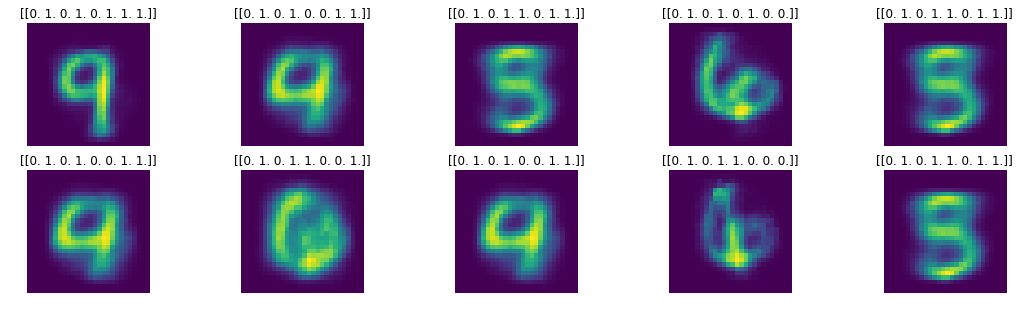

sample set 1
[[0. 1. 0. 1.]]


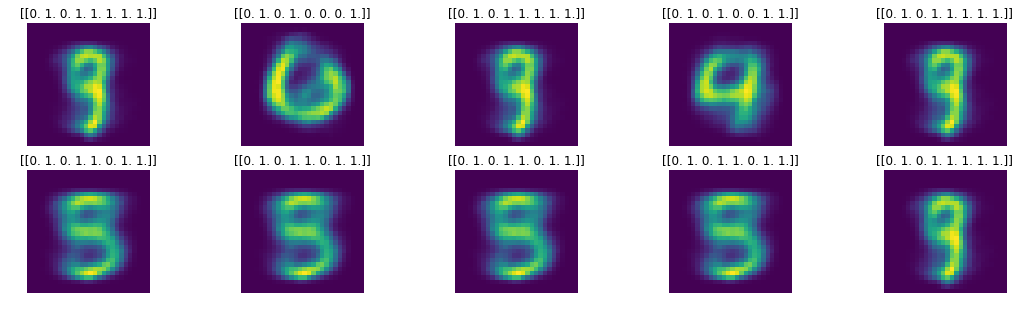

sample set 2
[[0. 1. 0. 1.]]


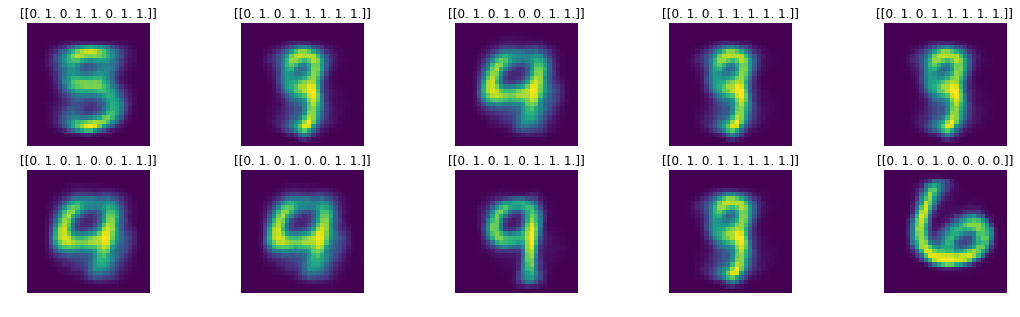

sample set 3
[[0. 1. 0. 1.]]


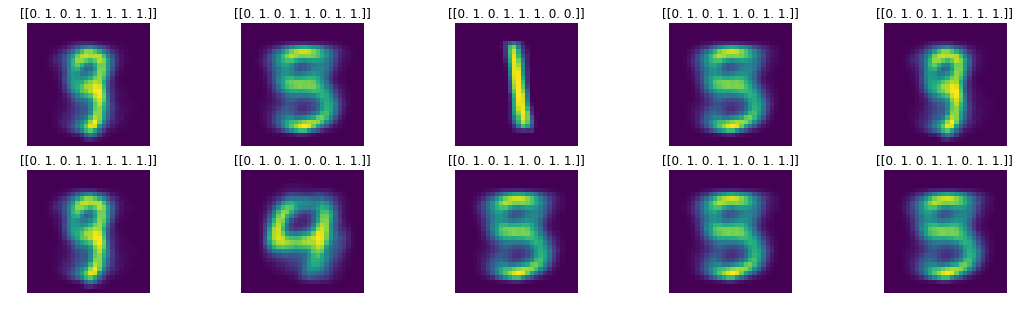

sample set 4
[[0. 1. 0. 0.]]


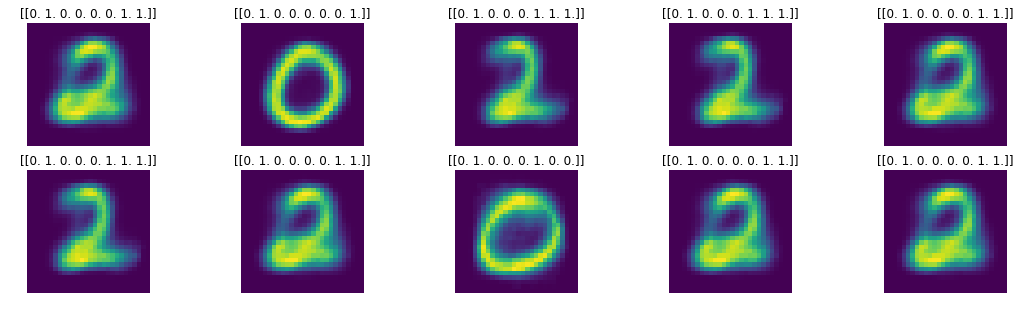

sample set 5
[[0. 1. 0. 1.]]


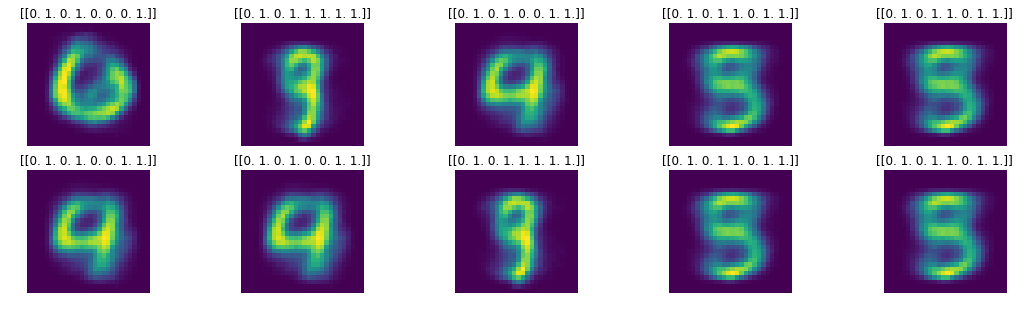

sample set 6
[[0. 1. 0. 1.]]


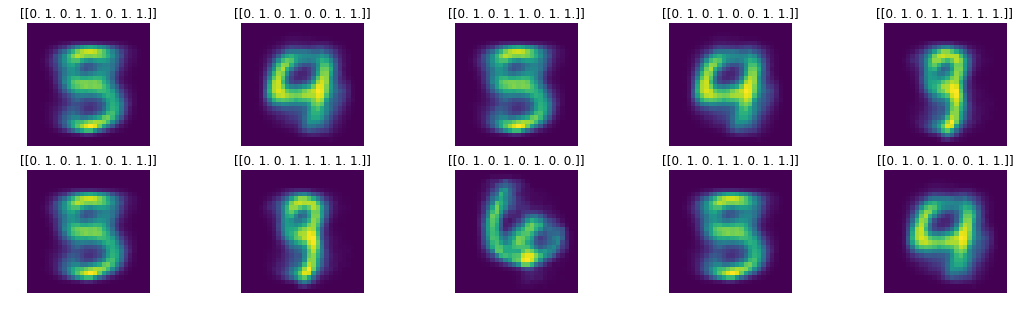

sample set 7
[[0. 0. 1. 0.]]


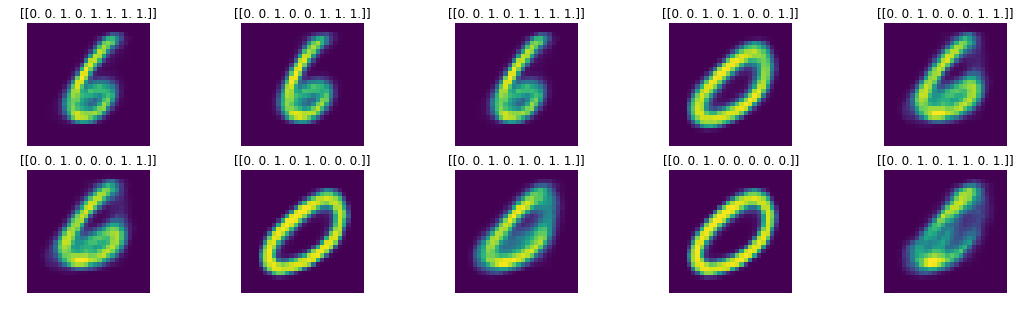

sample set 8
[[0. 1. 0. 0.]]


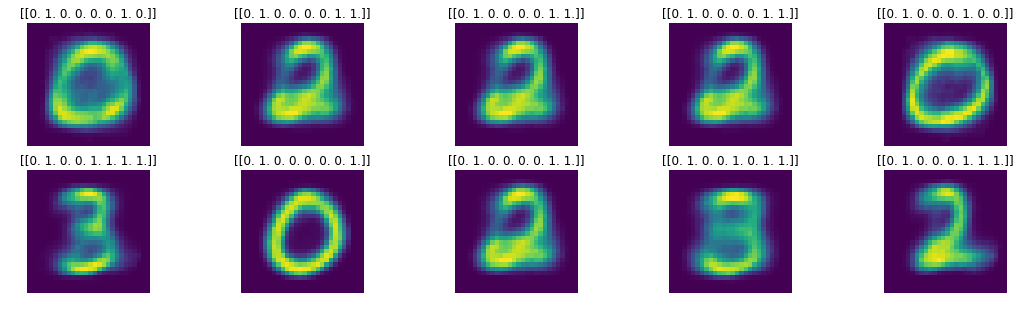

sample set 9
[[1. 1. 0. 1.]]


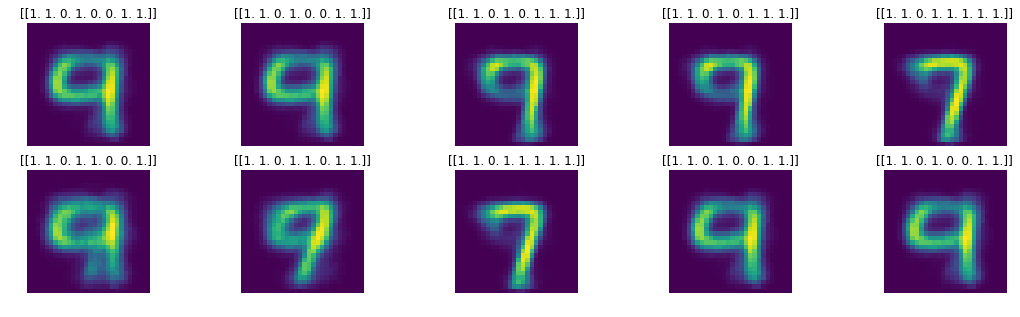

In [87]:
sample_plots(3)

In [121]:
from itertools import product
def plot_average_image(fixed_level):
    for path in list(product(range(2), repeat=fixed_level+1)):
        print(path)
        fixed = Variable(torch.Tensor(path))
        l = [fixed.repeat(100,1)]
        for level in range(fixed_level, NUM_LEVELS-1):
            c = torch.cat(l, dim=-1)
            l.append(hard_sample_binary_concrete(H.downwards[level](c)))
        whole = torch.cat(l, dim=-1)
        recovery = D(whole).view(100, 28,28).data.cpu().numpy()
        avg = np.mean(recovery, axis=0)
        plt.imshow(avg)
        plt.show()
        

(0, 0, 0, 0)


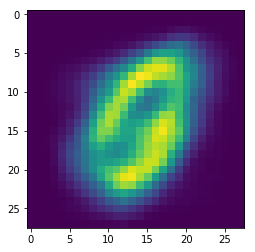

(0, 0, 0, 1)


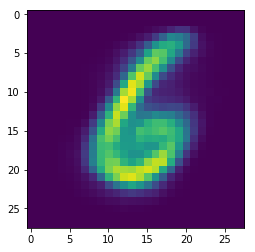

(0, 0, 1, 0)


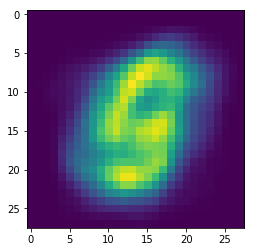

(0, 0, 1, 1)


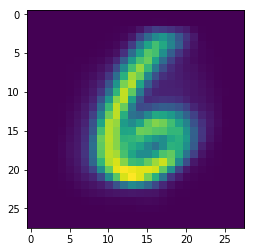

(0, 1, 0, 0)


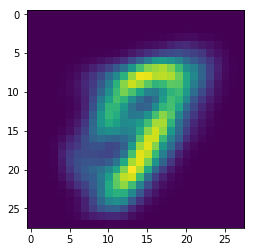

(0, 1, 0, 1)


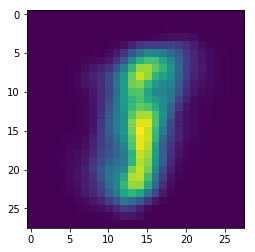

(0, 1, 1, 0)


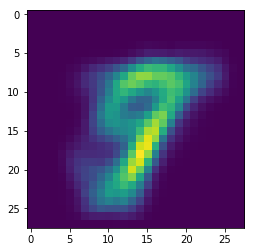

(0, 1, 1, 1)


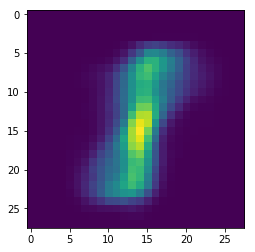

(1, 0, 0, 0)


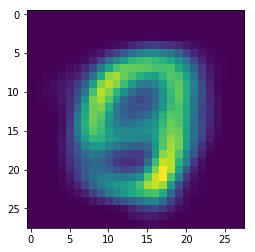

(1, 0, 0, 1)


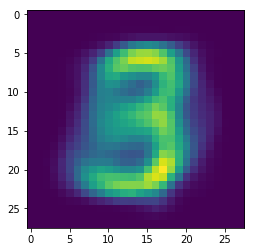

(1, 0, 1, 0)


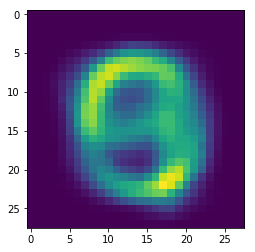

(1, 0, 1, 1)


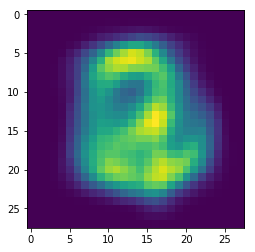

(1, 1, 0, 0)


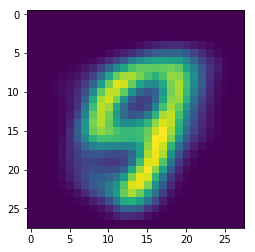

(1, 1, 0, 1)


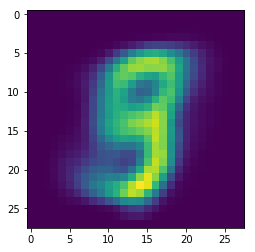

(1, 1, 1, 0)


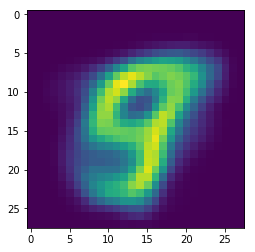

(1, 1, 1, 1)


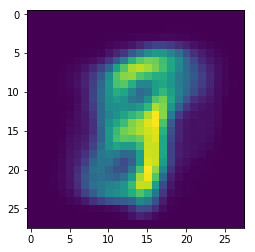

In [122]:
plot_average_image(3)